##Mount the Drive

In [ ]:
#Connect google drive folder with images
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


##Install Modules

In [ ]:
#General modules
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os, pathlib
import tensorflow_datasets as tfds
import cv2
import random

#Load the directory
from skimage.transform import resize
from skimage.io import imread
from sklearn.datasets import make_blobs

#Train & test the baseline model
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, classification_report, confusion_matrix
from sklearn.dummy import DummyClassifier
import seaborn as sns

##Load the Directory

In [ ]:
#Connect to the directory
plasticimagedir = '/content/drive/MyDrive/Plastic_images_dir'
os.chdir(plasticimagedir)
!ls

HDPE  LDPE  OTHER  PET	PP  PVC


## Visualise the Data

In [ ]:
#Load image directory
dataset = tf.keras.utils.image_dataset_from_directory(
    plasticimagedir,
    shuffle = True,
    seed=123,
    image_size = (150, 150),
    batch_size = 32
)

#Get the class names using the class_names attribute on the dataset
class_names = dataset.class_names
print(class_names)

Found 3195 files belonging to 6 classes.
['HDPE', 'LDPE', 'OTHER', 'PET', 'PP', 'PVC']


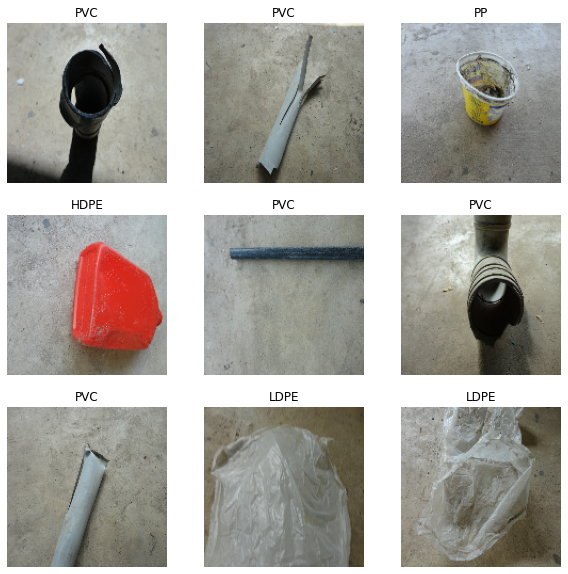

In [ ]:
#Visualise the first 9 images in the dataset
plt.figure(figsize=(10, 10))
for images, labels in dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
#Check the number of axes of the image tensor, using the ndim attribute. It should display 4 as images are Rank-4 tensors.
images.ndim

4

In [ ]:
#Check the shape of the image (samples, height, width, channels)
images.shape

TensorShape([32, 150, 150, 3])

## Pre-Process the Data

In [ ]:
#Categories of plastic types 
Categories=['HDPE', 'LDPE', 'OTHER', 'PET', 'PP', 'PVC']

#Image size
IMG_SIZE = 64

In [ ]:
#Code adapted from the following sources:
#1. https://www.kaggle.com/code/ashutoshvarma/image-classification-using-svm-92-accuracy
#2. https://medium.com/analytics-vidhya/image-classification-using-machine-learning-support-vector-machine-svm-dc7a0ec92e01

dataset_arr=[] #input array

#Loop through the categories
for i in Categories:
    print(f'loading... {i}') #display message to show that category is loading
    path=os.path.join(plasticimagedir,i) #join to the image directory
    class_index=Categories.index(i) #subdirectory name which is the inferred label
    class_len=len(os.listdir(path)) #get the number of files per category

    for img in os.listdir(path):
        try:
          img_array=cv2.imread(os.path.join(path,img))
          resized_array=cv2.resize(img_array,(IMG_SIZE, IMG_SIZE)) #resize images
          dataset_arr.append([resized_array,class_index])
        except Exception as e:
          pass
    print(f'loaded {i} successfully:', class_len) #display message to show that category has been loaded successfully

loading... HDPE
loaded HDPE successfully: 520
loading... LDPE
loaded LDPE successfully: 516
loading... OTHER
loaded OTHER successfully: 502
loading... PET
loaded PET successfully: 544
loading... PP
loaded PP successfully: 573
loading... PVC
loaded PVC successfully: 540


In [ ]:
#print the length of the newly created dataset array
lenofimage = len(dataset_arr)
print(lenofimage) 

3195


In [ ]:
#Shuffle the dataset so that the images are not in order of their class
dataset_shuffled = random.shuffle(dataset_arr)

In [ ]:
X=[] #array to store the image data
y=[] #array to store the labels

#loop through the dataset array, and save the image data and labels into separate arrays
#remember in the intial for loop, we saved both the resized array and labels into the dataset array
for imgdata, label in dataset_arr:
    X.append(imgdata)
    y.append(label)

#Reshape the array - X should now be a Rank-2 tensor (matrix) 
# sklearn expects a 2D array as input to the fit() function which will be called on the model during training., the second being height*width*channels
X= np.array(X).reshape(lenofimage,-1)

#Normalise the array - maintain the pixels of all the images within a uniform range.
X = X/255.0
print(X.shape)

#Y should now be a Rank-1 tensor (vector) as it is just the name of the label
y=np.array(y)
print(y.shape)

(3195, 12288)
(3195,)


## Train and Test the Baseline Model

In [ ]:
#split the dataset
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.20,random_state=77)

In [ ]:
#guidance from: https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html
#train the dataset using the Dummy Classifier
#“uniform”: generates predictions uniformly at random from the list of unique classes observed in y, i.e. each class has equal probability.
dummy_clf = DummyClassifier(strategy="uniform", random_state=123)

#fit the dataset to the Dummy Classifier
dummy_clf.fit(X_train, y_train)

#test the dataset with the Dummy Classifier
y_pred = dummy_clf.predict(X_test)

#print the metrics to give a baseline score
print('Accuracy:', accuracy_score(y_test, y_pred))
print('Recall:', recall_score(y_test, y_pred, average = 'weighted'))
print('Precision:', precision_score(y_test, y_pred, average='micro'))
print('F1_score:', f1_score(y_test, y_pred, average = 'macro'))

Accuracy: 0.17370892018779344
Recall: 0.17370892018779344
Precision: 0.17370892018779344
F1_score: 0.1730275856773146


In [ ]:
#print the classification report
print(classification_report(y_pred,y_test))

              precision    recall  f1-score   support

           0       0.19      0.18      0.19       104
           1       0.19      0.17      0.18       117
           2       0.12      0.12      0.12        97
           3       0.22      0.19      0.21       113
           4       0.16      0.21      0.19        99
           5       0.16      0.16      0.16       109

    accuracy                           0.17       639
   macro avg       0.17      0.17      0.17       639
weighted avg       0.18      0.17      0.17       639



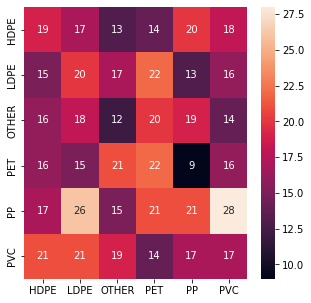

In [ ]:
#print the confusion matrix as an image
confmat = confusion_matrix(y_test, y_pred)
classes = Categories

#put the confusion matrix into a dataframe
df_confmat = pd.DataFrame(confmat, index = classes, columns = classes)

#plot the confusion matrix using a heatmap
plt.figure(figsize = (5,5))
confmat_plot = sns.heatmap(df_confmat, annot=True)

##Old Code
This was the code I used before, however, it was too computationally expensive to run. This code was run with 100 samples from 4 classes, but has not run on the full dataset.

Below we are using the Dummy Classifier from Sklearn to create a baseline model, on which we can compare the more complex models built during this project.

Using this classifier, the results are as following:

Accuracy: 25%
Precision: 25%
Recall: 25%
F1 Score: 0.24
The metrics above are close to 25% because the baseline model prediction distribution was uniform across four classes.

In [ ]:
#Connect to the directory
plasticimagedir = '/content/drive/MyDrive/Plastic_images_dir'
os.chdir(plasticimagedir)
!ls

In [ ]:
#Load image directory
dataset = tf.keras.utils.image_dataset_from_directory(
    plasticimagedir,
    shuffle = True,
    seed=123,
    image_size = (150, 150),
    batch_size = 32
)

#Get the class names using the class_names attribute on the dataset
class_names = dataset.class_names
print(class_names)

Found 3195 files belonging to 6 classes.
['HDPE', 'LDPE', 'OTHER', 'PET', 'PP', 'PVC']


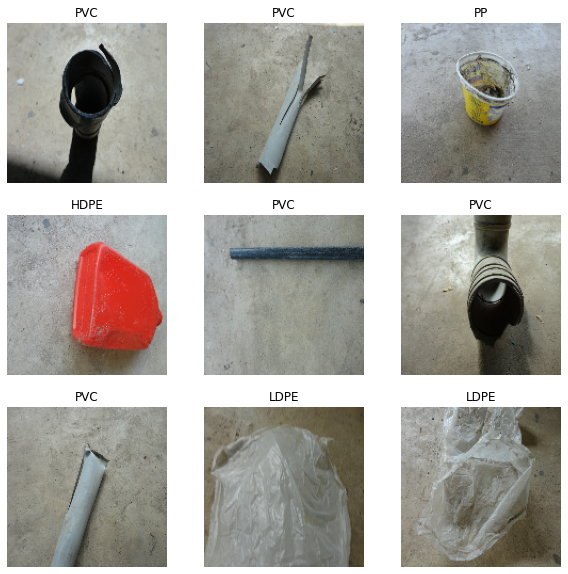

In [ ]:
#Visualise the first 9 images in the dataset
plt.figure(figsize=(10, 10))
for images, labels in dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
#Code adapted from: https://medium.com/analytics-vidhya/image-classification-using-machine-learning-support-vector-machine-svm-dc7a0ec92e01
#Categories of plastic types 
Categories=['HDPE', 'LDPE', 'OTHER', 'PET', 'PP', 'PVC']

flat_data_arr=[] #input array
target_arr=[] #output array

#Loop through the categories
for i in Categories:
    print(f'loading... category : {i}') #display message to show that category is loading
    path=os.path.join(plasticimagedir,i) #join to the image directory

    for img in os.listdir(path):
        img_array=imread(os.path.join(path,img))
        img_resized=resize(img_array,(224,224,3)) #resize images as the SVM should receive inputs of one size
        flat_data_arr.append(img_resized.flatten())
        target_arr.append(Categories.index(i))
    print(f'loaded category:{i} successfully') #display message to show that category has been loaded successfully

flat_data=np.array(flat_data_arr)
target=np.array(target_arr)

df1=pd.DataFrame(flat_data) #dataframe
df1['Target']=target
x=df1.iloc[:,:-1] #input data 
y=df1.iloc[:,-1] #output data

loading... category : HDPE
loaded category:HDPE successfully
loading... category : LDPE
loaded category:LDPE successfully
loading... category : OTHER
loaded category:OTHER successfully
loading... category : PET
loaded category:PET successfully
loading... category : PP
loaded category:PP successfully
loading... category : PVC
loaded category:PVC successfully


In [ ]:
#split the dataset
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.20,random_state=77,stratify=y)

In [ ]:
#guidance from: https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html
#train the dataset using the Dummy Classifier
#“uniform”: generates predictions uniformly at random from the list of unique classes observed in y, i.e. each class has equal probability.
dummy_clf = DummyClassifier(strategy="uniform")

#fit the dataset using the Dummy Classifier
dummy_clf.fit(x_train, y_train)

#test the dataset using the Dummy Classifier
y_pred = dummy_clf.predict(x_test)

#print the metrics to give a baseline score
print('Accuracy:', accuracy_score(y_test, y_pred))
print('Recall:', recall_score(y_test, y_pred, average = 'weighted'))
print('Precision:', precision_score(y_test, y_pred, average='micro'))
print('F1_score:', f1_score(y_test, y_pred, average = 'macro'))

Accuracy: 0.25
Recall: 0.25
Precision: 0.25
F1_score: 0.24315661815661815


In [ ]:
print(classification_report(y_pred,y_test))

              precision    recall  f1-score   support

           0       0.40      0.29      0.33        28
           1       0.25      0.26      0.26        19
           2       0.15      0.19      0.17        16
           3       0.20      0.24      0.22        17

    accuracy                           0.25        80
   macro avg       0.25      0.24      0.24        80
weighted avg       0.27      0.25      0.26        80

